In [1]:
from tensorly.metrics.regression import RMSE
import time
import scipy.io
import tensorly as tl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorly.cp_tensor import CPTensor
from nn_parafac_normalization_comparison import *
import musicntd.model.features as features
import musicntd.data_manipulation as dm
import musicntd.tensor_factory as tf
import soundfile as sf
#audio
data,sampling_rate = sf.read('/home/ctuna/tensoptly/benchmark_data/Audio/The Beatles - Come Together.wav')

#Parameters
rank=10
init='random'
hop_length = 512
n_fft = hop_length * 4
hop_length_seconds = hop_length/sampling_rate


stft_spec = features.get_spectrogram(data[:,0], sampling_rate, 
                                     feature="stft", n_fft = n_fft, hop_length = hop_length)
bars = dm.get_bars_from_audio('/home/ctuna/tensoptly/benchmark_data/Audio/The Beatles - Come Together.wav')

tensor = tf.tensorize_barwise(stft_spec, bars, hop_length_seconds, 40)

/usr/local/lib64/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/usr/local/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


hop_length a 44100Hz = 512, normal ?


1. Method from PR
2. Inner loop normalization with last factor normalization after inner loop
3. Normalization at the end
4. 2 and 3 together

In [2]:
#normalized improved nonnegative parafac result
tic = time.time()
tensornorm1, errorsnorm1 = non_negative_parafac_normalize_1(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True, n_iter_max=100)
weightsnorm1, factorsnorm1 = tensornorm1
cp_reconstructionnorm1 = tl.cp_to_tensor((weightsnorm1, factorsnorm1))
time_cp1 = time.time() - tic

#normalized improved nonnegative parafac result
tic = time.time()
tensornorm2, errorsnorm2 = non_negative_parafac_normalize_2(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True, n_iter_max=100)
weightsnorm2, factorsnorm2 = tensornorm2
cp_reconstructionnorm2 = tl.cp_to_tensor((weightsnorm2, factorsnorm2))
time_cp2 = time.time() - tic

#normalized improved nonnegative parafac result
tic = time.time()
tensornorm3, errorsnorm3 = non_negative_parafac_normalize_3(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True, n_iter_max=100)
weightsnorm3, factorsnorm3 = tensornorm3
cp_reconstructionnorm3 = tl.cp_to_tensor((weightsnorm3, factorsnorm3))
time_cp3 = time.time() - tic

#normalized improved nonnegative parafac result
tic = time.time()
tensornorm4, errorsnorm4 = non_negative_parafac_normalize_4(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True, n_iter_max=100)
weightsnorm4, factorsnorm4 = tensornorm4
cp_reconstructionnorm4 = tl.cp_to_tensor((weightsnorm4, factorsnorm4))
time_cp4 = time.time() - tic

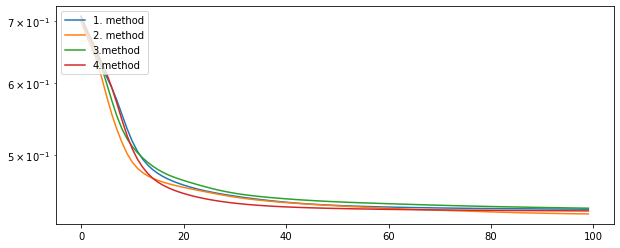

In [3]:
each_iteration(errorsnorm1, errorsnorm2, errorsnorm3, errorsnorm4)

In [4]:
print(weightsnorm1[:4])
print(weightsnorm2[:4])
print(weightsnorm3[:4])
print(weightsnorm4[:4])

[110430.74 110948.6  124051.37 164742.27]
[159394.56 128664.56 263034.88 131109.72]
[170533.    90564.98 144190.38 141337.36]
[114908.94 147556.58 195180.72 205188.89]


In [5]:
print(tl.mean(factorsnorm1[0]), tl.mean(factorsnorm1[1]), tl.mean(factorsnorm1[2]))
print(tl.mean(factorsnorm2[0]), tl.mean(factorsnorm2[1]), tl.mean(factorsnorm2[2]))
print(tl.mean(factorsnorm3[0]), tl.mean(factorsnorm3[1]), tl.mean(factorsnorm3[2]))
print(tl.mean(factorsnorm4[0]), tl.mean(factorsnorm4[1]), tl.mean(factorsnorm4[2]))

0.0018186632 0.116908796 0.062489163
0.0017992113 0.10538902 0.06751362
0.0016992847 0.11373812 0.06560698
0.0016639039 0.09900475 0.07099867


In [6]:
print(RMSE(tensor,cp_reconstructionnorm1))
print(RMSE(tensor,cp_reconstructionnorm2))
print(RMSE(tensor,cp_reconstructionnorm3))
print(RMSE(tensor,cp_reconstructionnorm4))

172.44977
170.43321
172.90067
171.73122


In [7]:
print(str(time_cp1))
print(str(time_cp2))
print(str(time_cp3))
print(str(time_cp4))

6.3412744998931885
6.194763422012329
6.169338226318359
6.481285095214844
